<a href="https://colab.research.google.com/github/tolnaes/ml/blob/main/K_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# All necessary packages and functions imports here
import random
import numpy as np
from scipy.spatial import distance_matrix
import pandas as pd
%matplotlib
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn.cluster import KMeans
from google.colab import drive
import progressbar
from joblib import Parallel, delayed
import joblib
import math


Using matplotlib backend: agg


In [2]:
drive.mount('/content/gdrive/')

n = 1 # Number of centroids to relocate at a time when using ReloKmeans. Default is set to 1

def read_data_and_gt(filename):
  """
  Function to read from drive based on prefix of filename (i.e. "s1")
  :param filename: prefix of filename
  :return: Data in df, ground truth in df, and gt in ndarray, number of clusters k
  """

  # Reads in data set and ground truth as pandas dataframe
  df = pd.read_csv(f"/content/gdrive/My Drive/Maskinlæring/Prosjekt/datasets/{filename}.txt", delim_whitespace="    ", names = ['x', 'y'])
  ground_truth_df = pd.read_csv(f"/content/gdrive/My Drive/Maskinlæring/Prosjekt/datasets/{filename}_gt.txt", delim_whitespace="    ", names = ['x', 'y'])

  # Convert centroids to simple format [[point], [point],...]
  gt = ground_truth_df.values.tolist()

  # REMEMBER TO UPDATE THESE AS YOU CHANGE DATA SET
  k = len(gt) # Number of clusters in data set

  return df, ground_truth_df, gt, k

# Global variables to work with when testing
# df, ground_truth_df, gt, k = read_data_and_gt("s1")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [3]:
def distance(a, b, p):
    """
    Returns power distance between two points
    (p = 1 gives manhattan, p = 2 gives squared euclidian and so on)
    :param a: input point a
    :param b: input point b
    :param p: power to calculate distance in
    :return: distance between points raised to power p
    """
    diff = np.array(a) - np.array(b)
    diff = abs(diff)
    return sum(diff**p)
print(distance([0,0], [2,2], 1))


4


In [4]:
def SSE(cluster_pts):
    """
    Calculates the Sum Squared Error (variance) within a cluster
    :param cluster_pts: list of points in a single cluster
    :return: float SSE
    """
    center = tuple(np.average(cluster_pts, axis=0))
    return sum(distance(center, point, 2) for point in cluster_pts)

print(SSE([(1,1),(2,2),(3,3)]))
print(SSE([(1,1),(1,1),(1,1)]))

4.0
0.0


In [5]:
def score(clustering):
  """
  Finds score (total SSE) of an output clustering. That is, total SSE for all clusters in a partition
  :param clustering: dictionary with {index : List of list of points (i.e. list of clusters)}
  :return: float total SSE 
  """
  clusters = clustering.values()
  return sum(SSE(cluster_pts=cluster) for cluster in clusters)

print(score({0: [(1,1),(2,2),(3,3)],
             1: [(1,1),(1,1),(1,1)]}))

4.0


In [6]:
def convert_to_dict(data, labels):
    """
    Function for converting Kmeans output labels and data set into dictionary of labeled clusters
    :param data: Data points in pandas dataframe format
    :param labels: labels for each point (row) in dataframe
    :return: Labeled clusters. Dict with key:values as label: <List(points)>
    """
    matrix = data.values.tolist()
    clustering = {}
    for i, label in enumerate(labels):
        if label in clustering.keys():
            clustering[label].append(tuple(matrix[i]))
        else:
            clustering[label] = [tuple(matrix[i])]
    return clustering

In [7]:
def reduce_centroids(centroids, n):
    """
    Recursively reduces list of centroids by joining closest pair until new list of centroids contains n less than input
    :param centroids: Input centroid to be reduced
    :param n: number of centroids to remove
    :return: List of new centroids 
    """
    k = len(centroids)

    # Base case
    if n == 0:
        return centroids

    centroid_distances = distance_matrix(centroids, centroids)
    # Checking half of distance matrix excluding diagonal
    centroid_pairs = []
    for i in range(1, k):
        for j in range(0, i):
            centroid_pairs.append((i, j))
    sorted_pairs_by_dist = sorted(centroid_pairs, key=lambda pair: centroid_distances[pair[0], pair[1]])
    closest_pair = sorted_pairs_by_dist.pop(0)
    index1, index2 = closest_pair[0], closest_pair[1]
    c1, c2 = centroids[index1], centroids[index2]
    joined_centroid = tuple(np.average([c1, c2], axis=0))
    centroids.remove(c1)
    centroids.remove(c2)
    centroids.append(joined_centroid)
    return reduce_centroids(centroids, n-1)


In [8]:
def improve_centroids(clusters, n=1):
    """
    Relocates centroids from dense areas to high-variance clusters.
    Step one: Finding n "worst" clusters, i.e. clusters with highest variance
    Step two: Finding n closest pairs of centroids (excluding worst), merging these into one, thus freeing up n centroids
    Step three: Placing two centroids instead of one in each of the n worst clusters, using a furthest point heuristic
    :param clusters: Dictionary containing numbered clusters (Output after running Kmeans on a data set)
    :param n: number of clusters to improve at once. Default is 1 because multiple at once might cause optimal solution 
    to be skipped
    :return: list of new centroid positions, i.e. input for another initialization of Kmeans.
    """
    k = len(clusters.keys())
    # Verify that n is not larger than k/2, as that would not make sense for this operation
    assert n < k / 2
    
    # Step one
    n_worst_clusters = sorted(clusters.values(), key=lambda cluster_pts: SSE(cluster_pts), reverse=True)[:n]
    n_worst_centroids = [tuple(np.average(cluster_pts, axis=0)) for cluster_pts in n_worst_clusters]

    # Step two
    remaining_clusters = sorted(clusters.values(), key=lambda cluster_pts: SSE(cluster_pts), reverse=True)[n:]
    remaining_centroids = [tuple(np.average(cluster, axis=0)) for cluster in remaining_clusters]
    new_centroids = reduce_centroids(remaining_centroids, n)

    # Verify that n centroids have been freed up by joining n close pairs (n worst are also currently missing at this point)
    assert len(new_centroids) == k-2*n  

    # Step three 
    # (ignores old centroid, places two new by first random selection and then point furthest away using manhattan dist)
    for cluster in n_worst_clusters:
        first_centroid = [random.choice(cluster)].copy()[0]
        furthest_away_centroid = sorted(cluster, key=lambda point: distance(point, first_centroid, 1))[-1]
        new_centroids.extend([first_centroid, furthest_away_centroid])
    
    # Verify that final number of centroids has not changed
    assert len(new_centroids) == k

    return new_centroids


In [9]:
def ReloKmeans(data, k=8, n=1, random_initial=True, max_iter=300, rec_params=None):
    """
    Function for repeating Kmeans while improving centroids every time.
    Repetition is done until result stops improving, i.e. when score(clustering) increases
    Uses Sklearns KMeans for each run.

    :param rec_params: Parameters passed in case n>1 and a recursive call is made with n=1.
    format will be (result_clustering, scores, plotting_list)
    :param max_iter: Number of iterations for before termination of each run of Kmeans
    :param random_initial: Whether to use random or Kmeans++ initialization for first run
    :param data: input data points in pandas dataframe format
    :param k: number of clusters
    :param n: number of clusters to improve at a time. Default is 1 to avoid "skipping over" optimal solution
    If n>1 recursive call is made with n=1 to ensure optimal solution is found
    :return: clustering solution and plotting list of centroids
    """
    run_times = [] # Recording run times for each call to KMeans()
    # Checking if we are in recursive call or not
    if rec_params is None:
        
        start = time.time()
        
        km = KMeans(n_clusters=k,
                    init="random" if random_initial else "k-means++",
                    algorithm="elkan",
                    n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                    max_iter=max_iter).fit(data.to_numpy())
        run_times.append(time.time()-start)

        # Output of initial run is scored
        current_clustering = convert_to_dict(data, km.labels_)
        current_score = score(current_clustering)

        # Keeping track of centroids produced for plotting purposes
        plotting_list = []
        current_centroids = km.cluster_centers_
        plotting_list.append(current_centroids)

        # Keeping track of scores (SSE) for different runs
        scores = [current_score]
    else:
        current_clustering = rec_params[0]
        scores = rec_params[1]
        plotting_list = rec_params[2]
        run_times = rec_params[3]
        current_score = min(scores) # Best score reached from previous call

    # Try to improve by relocating n centroids
    new_centroids = improve_centroids(current_clustering, n=n)

    start = time.time()
    # Run K-means again with new initial centroids (improved centroids from previous run)
    new_km = KMeans(n_clusters=k,
                    init=np.array(new_centroids),
                    algorithm="elkan",
                    n_init=1,
                    # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                    max_iter=max_iter).fit(data.to_numpy())
    run_times.append(time.time()-start)
    
    # Output of new run is scored
    new_clustering = convert_to_dict(data, new_km.labels_)
    new_score = score(new_clustering)

    # Score is saved
    scores.append(new_score)

    while new_score < current_score:  # Continue improving centroids until score stops decreasing

        # Record new centroids for plotting (Don't want to plot last centroids, since these will be worse
        result_centroids = new_km.cluster_centers_
        plotting_list.append(result_centroids)

        # Move "current" to new, since new_score was better
        current_score = new_score
        current_clustering = new_clustering

        # Try to improve by relocating n centroids
        new_centroids = improve_centroids(current_clustering, n=n)

        start = time.time()
        # Run K-means again with new initial centroids
        new_km = KMeans(n_clusters=k,
                        init=np.array(new_centroids),
                        algorithm="elkan",
                        n_init=1,
                        # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
                        max_iter=max_iter).fit(data.to_numpy())
        run_times.append(time.time()-start)

        # Output of new run is scored
        new_clustering = convert_to_dict(data, new_km.labels_)
        new_score = score(new_clustering)

        # Score is saved
        scores.append(new_score)

    # If n was >1 then we need to check result with n=1 to make sure optimal solution was not overshot
    if n > 1:
        rec_params = (current_clustering, scores, plotting_list)
        return ReloKmeans(data, k=k, n=1, max_iter=max_iter, rec_params=rec_params)

    return current_clustering, plotting_list, scores, run_times

In [10]:
def convert_to_pd_series(centroids):
    """
    Function to convert data for 2D-plotting
    :param centroids: list of centroids
    :return: lists of x coordinates and y coordinates of centroids
    """
    centroids_x = pd.Series([point[0] for point in centroids])
    centroids_y = pd.Series([point[1] for point in centroids])
    return centroids_x, centroids_y


In [11]:
def plot_centroids(plotting_list, gt_df=None):
    """
    Function for plotting centroids and ground thruth
    :param plotting_list: Sets of centroids from different runs to be plottet 
    :param gt_df: Ground thruth centroids from data set source
    :return:
    """
    num_centroids = len(plotting_list)

    figure = plt.figure(figsize=[15,15])
    
    # Plot data points
    plt.scatter(df['x'], df['y'], s=10)

    # Plot centroids in plotting list (normally only two sets of centroids)
    for i, centroids in enumerate(plotting_list):
        marker, color, size, alpha = ("*", "gold", 400, 1) if i == num_centroids-1 else ("X", "black", 250, 0.6)

        cent_x, cent_y = convert_to_pd_series(centroids)
        plt.scatter(cent_x, cent_y, marker=marker, c=color, s=size, alpha=alpha,
                    linewidths=1, edgecolors="black")

    # Plot ground truth if available
    if gt_df is not None:
        plt.scatter(gt_df["x"], gt_df["y"], marker="o", c="magenta", s=50)


In [12]:
def CI_score(gt, centroids):
  """
  Function for comparing result to ground truth
  Source:
  https://www.sciencedirect.com/science/article/pii/S0031320314001150#bib21

  Maps each centroid in gt to its closest neighbor in "centroids",
  Returns number of centroids in "centroids" that have no gt centroids mapped to it
  
  :param gt: Ground truth centroids in ndarray
  :param centroids: Result centroids after running Kmeans or ReloKmeans
  :return: CI-value for a clustering
  """
  assert len(gt) == len(centroids)

  dist_matrix = distance_matrix(gt, centroids)**2 # Squared euclidian distances

  gt_to_centroids_mapping = [] # [2, 0,...] means gt[0]->centroids[2], gt[1]->centroids[0], ...
  for row in dist_matrix:
    gt_to_centroids_mapping.append(np.argmin(row))

  # Orphans are not mapped to by any gt centroid, want to return number of orphans
  orphans = set([i for i in range(len(centroids)-1)])-set(gt_to_centroids_mapping)
  
  return len(orphans)



In [13]:
# Run time analysis

def find_average_run_times(n_runs):
  """
  Function to run ReloKMeans a number of times and record average run time for each call to sklearn.KMeans() within the process

  :param n_runs: number of runs to perform
  :return: A list of average run times for 1st, 2nd, 3rd (and so on) calls to sklearn clustering function 
  """
  total = []
  bar = progressbar.ProgressBar(maxval=n_runs, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  for i in range(n_runs):
    _, __, ___, run_times =  ReloKmeans(df,random_initial=True, k=k, n=n)
    # Excluding last run time (which takes slightly longer) but we ignore this
    # to illustrate the effect of closing in on global optimum
    for j, runtime in enumerate(run_times[:-1]): 
      bar.update(i+1)
      if j>len(total)-1:
        total.append(runtime)
      else:
        total[j] += runtime
  bar.finish()
  avg = np.array(total)/n_runs
  return avg

def plot_avg_run_times(avg):
  """
  Function for plotting average run times
  :param avg: List of average run times from function find_avg_run_times()
  """
  plt.figure(figsize=[15,10])
  plt.title("Average run time for each call to KMeans function")
  plt.rc('xtick', labelsize=20)
  plt.rc('ytick', labelsize=20)
  plt.xticks([i+1 for i in range(len(avg))], ('1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th'))
  plt.ylabel("Seconds", fontsize=20)
  plt.xlabel("Function calls", fontsize=20)
  plt.plot([i+1 for i in range(len(avg))], avg)

#avg = find_avg_run_times(n_runs=1000)
#plot_avg_run_times(avg)

In [14]:
# FOR COMPARING ReloKmeans TO SKLEARN KMEANS (running multiple times on same data set)

def repeat_until_correct(data, gt, cutoff, random_initial, k):
  """
  Help function for repeating Kmeans until a result is correct (CI=0). 
  If CI=0 is not reached after cutoff the function returns attempts = cutoff 
  and smallest ci value acheived before cutoff
  :params: See multiple_trials() description
  :return: (Number of attempts until success, min_ci=0) or (cutoff, smallest ci acheived)
  """
  km = KMeans(n_clusters=k,
              init="random" if random_initial else "k-means++",
              algorithm="elkan",
              n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
              ).fit(data.to_numpy())
  result = km.cluster_centers_
  ci = CI_score(gt, result)
  min_ci = ci # Keeping track of lowest ci acheived in case no termination until cutoff
  attempts = 1
  while attempts < cutoff and ci!=0:
    km = KMeans(n_clusters=k,
              init="random" if random_initial else "k-means++",
              algorithm="elkan",
              n_init=1,  # Don't want to run Kmeans multiple times with our algorithm (default is 10 repeats)
              ).fit(data.to_numpy())
    result = km.cluster_centers_
    ci = CI_score(gt, result)
    min_ci = min((min_ci, ci))
    attempts += 1
  return attempts, min_ci

def mulitple_trials(n_trials, data, gt, k, n,relokm=True, random_initial=True, cutoff=100):
  """
  Function for running ReloKmeans or Kmeans multiple times and recording number of calls
  to Kmeans until convergence for each execution, as well as CI index when termination does not occur before cutoff
  :param n_trials: number of trials to record
  :param data: pandas dataframe containing data points to be clustered
  :param gt: ground truth centroids for data set
  :param relokm: Boolean value deciding which of the clustering algorithms to use
  :param threshold_percentage: Percentage of offset to allow for when classifying result centroids
  :param random_initial: whether to use naive or k++ initialization for first run
  :param k: number of clusters (assumed to be known from data set)
  :param n: number of centroids to relocate at a time, default is 1
  """
  number_of_calls = []
  CI_values = []

  # Progress bar for monitoring process 
  bar = progressbar.ProgressBar(maxval=n_trials, \
      widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
  bar.start()
  
  if relokm:
    for i in range(n_trials): 
      clustering, plotting_list, scores, run_times = ReloKmeans(data, random_initial=random_initial, k=k, n=n)
      result = plotting_list[-1]
      ci = CI_score(gt, result)
      number_of_calls.append(len(scores)) # Records scores after every call, so just count those
      CI_values.append(ci)
      bar.update(i+1)
  else:
    for i in range(n_trials): 
      attempts, min_ci = repeat_until_correct(data, gt, cutoff, random_initial, k)
      number_of_calls.append(attempts)
      CI_values.append(min_ci) # Whenever min_ci is not 0 we know cutoff happened
      bar.update(i+1)

  bar.finish()
  return CI_values, number_of_calls


In [15]:
# Code for performing trials. 
# Each of the four versions of Kmeans are run for n_trials
# And number of attempts to reach success is recorded/fails are recorded if cutoff

def collect_tasks_for_each_algo(filename, n_trials = 1000, cutoff=100):
  """
  Collects tasks for processes to run n_trials on data set and records results for all 4 algorithms
  :param n_trials: Number of trials to complete for each algo
  :param filename: name of data set, e.g. "s1"
  :return: 4 tasks (delayed, using joblib)
  """
  df, ground_truth_df, gt, k = read_data_and_gt(filename)

  algo_settings = {"NKM": (False, True),
                  "ReloKM": (True, True),
                  "KM++": (False, False),
                  "ReloKM++": (True, False)
                  }
  algonames = [name for name in algo_settings.keys()]
  # Arguments to pass into multiple_trials() for each algo

  algo_results = {}

  # Running 4 threads 
  tasks = [delayed(mulitple_trials)(n_trials, df, gt, k, 1,algo_settings[alg][0], algo_settings[alg][1], cutoff) for alg in algo_settings.keys()]

  return tasks

In [16]:
def print_results(algo_results, setname):
  "Prints out trial results nicely for every algo in algo results"
  print("="*100)
  print(f"{setname.upper()} Data Set".rjust(27))
  print("="*100)

  for algo in algo_results.keys():
    print("="*100)
    print(f"#################   {algo}    ######################################")
    ci_vals, ncalls = algo_results[algo] # Idx 0 means first trial, so ci_vals[0] is min ci acheived and ncalls[0] is number of calls made during first trial 

    success_ncalls = [] # All trials where ci_val=0
    failed_ci_vals = [] # All trials where ci_val>0
    failed_ncalls = [] # Number of calls before fail (will be equal to cutoff+1 for RKM)
    for i, ci_val in enumerate(ci_vals):
      if ci_val==0:
        success_ncalls.append(ncalls[i])
      else:
        failed_ci_vals.append(ci_val)
        failed_ncalls.append(ncalls[i])

    n_success = len(success_ncalls)
    n_fails = len(failed_ci_vals)

    avg_success_ncalls = None if n_success == 0 else np.mean(success_ncalls)      # What is the average number of calls required to reach CI=0?
    avg_fail_ci_val = None if n_fails == 0 else np.mean(failed_ci_vals)           # When it fails, what is the average CI value it acheives?
    avg_fail_ncalls = None if n_fails == 0 else np.mean(failed_ncalls)            # When it fails, how many calls does it make on average?

    print("Number of successes".ljust(35), f": {n_success}")
    print("Number of fails".ljust(35), f": {n_fails}")
    print("Average repetitions to reach CI=0".ljust(35), f": {avg_success_ncalls}")
    print("Average achieved CI at failure".ljust(35), f": {avg_fail_ci_val}")
    print("Average number of calls at failure".ljust(35), f": {avg_fail_ncalls}")

In [17]:
def run_trials_on_all_data_sets(setnames, n_trials=1000, cutoff=100):
  """
  To be executed with a list of data set names, and leave overnight!
  Runs on multiple processes (CPUs) if available
  """
  algo_names = ["NKM","ReloKM", "KM++", "ReloKM++"]
  data_set_results = {}

  executor = Parallel(n_jobs=-1, backend= 'multiprocessing')
  tasks = []
  for setname in setnames:
    tasks.extend(collect_tasks_for_each_algo(setname, n_trials, cutoff))
  results = executor(tasks)
  algo_results = {} # Temporarily holds results for each algo on a single data set
  for i, algo_result in enumerate(results):

    algo = algo_names[i%4]
    setname = setnames[math.floor(i/4)]
    if i%4 == 0:
      algo_results[algo] = algo_result
      data_set_results[setname] = algo_results
    else:
      algo_results[algo] = algo_result
  return data_set_results

# setnames = ["s1","s2","s3","s4", "a1",
setnames = ["a2", "a3"]
#setnames = ["b2_k15","b2_k25","b2_k50","b2_k75", "b2_k100"]

data_set_results = run_trials_on_all_data_sets(setnames, n_trials = 1, cutoff = 10)




[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%
[========================================================================] 100%


In [18]:
for setname, algo_results in data_set_results.items():
  print_results(algo_results, setname)

                A2 Data Set
#################   NKM    ######################################
Number of successes                 : 0
Number of fails                     : 1
Average repetitions to reach CI=0   : None
Average achieved CI at failure      : 5.0
Average number of calls at failure  : 10.0
#################   ReloKM    ######################################
Number of successes                 : 1
Number of fails                     : 0
Average repetitions to reach CI=0   : 8.0
Average achieved CI at failure      : None
Average number of calls at failure  : None
#################   KM++    ######################################
Number of successes                 : 1
Number of fails                     : 0
Average repetitions to reach CI=0   : 10.0
Average achieved CI at failure      : None
Average number of calls at failure  : None
#################   ReloKM++    ######################################
Number of successes                 : 1
Number of fails                   

Time taken                     : 0.614 seconds
First score achieved           : 44597105774.76505
Lowest score achieved          : 44597105774.76505
Score of returned solution     : 44597105774.76505


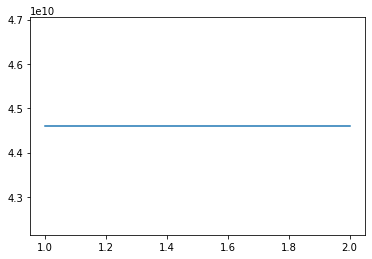

In [19]:
# MAIN RUN BLOCK

start = time.time()
df, ground_truth_df, gt, k = read_data_and_gt("b2_k100")
improved_clustering, plotting_list, scores, run_times = ReloKmeans(df,random_initial=False, k=k, n=n)
tot = time.time()-start

#plt.plot([i+1 for i in range(len(run_times))], run_times)

plt.plot([i+1 for i in range(len(scores))], scores)

print("Time taken".ljust(30), ": {0:.3f} seconds".format(time.time()-start))

print("First score achieved".ljust(30), ": {}".format(scores[0]))
print("Lowest score achieved".ljust(30), ": {}".format(min(scores)))
print("Score of returned solution". ljust(30), ": {}".format(score(improved_clustering)))

Returned solution:
Centroid Index: 0

First solution:
Centroid Index: 0


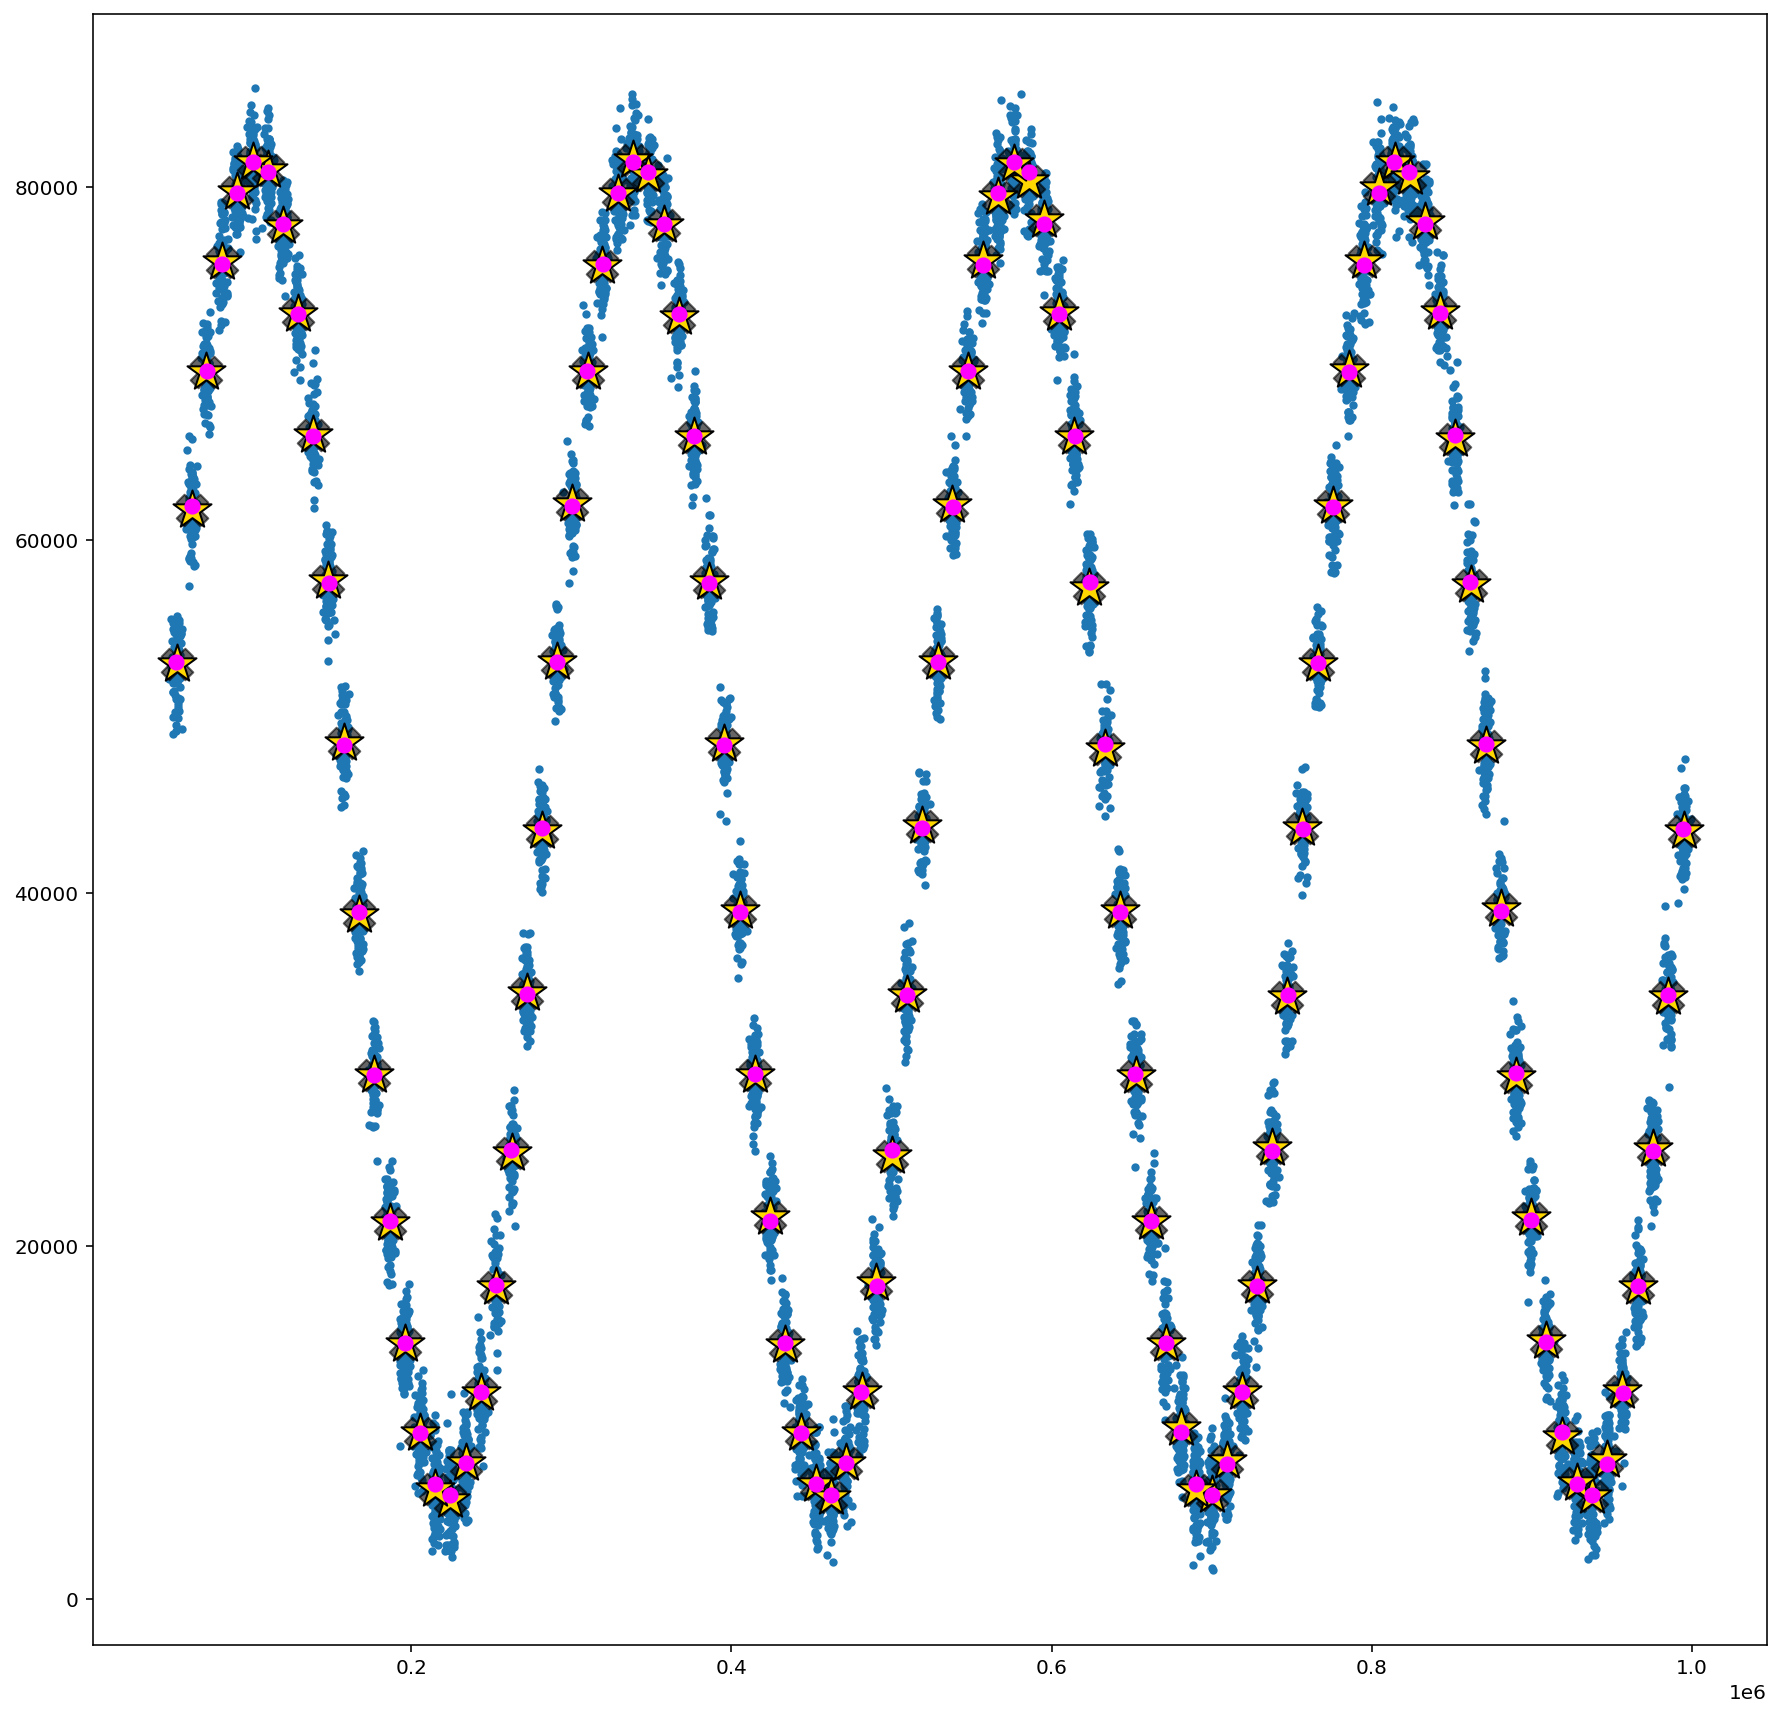

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
result = plotting_list[-1]
initial = plotting_list[0]

print("Returned solution:")
print("Centroid Index:", CI_score(gt, result))
print()
print("First solution:")
print("Centroid Index:", CI_score(gt, plotting_list[0]))

#normal = KMeans(n_clusters = k, init="k-means++", n_init=10, max_iter=300).fit(df.to_numpy())

plot_centroids([initial, result], gt_df=ground_truth_df)